In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name = 'gpt2-medium'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [3]:
time_steps = 8
choices_per_step = 5

def get_next_token_greedy_search(input_txt, input_ids):
    iterations = []  # Initialize list to store results

    with torch.no_grad():
        for _ in range(time_steps):
            iteration_dict = dict()  # Store results for each step
            iteration_dict['Input'] = tokenizer.decode(input_ids[0])

            output = model(input_ids)
            next_token_logits = output.logits[0, -1, :]

            # Convert logits to probabilities
            next_token_probabilities = torch.softmax(next_token_logits, dim=-1)

            # Sort indices by probability in descending order
            sorted_indices_of_next_token_proba = torch.argsort(next_token_probabilities, descending=True)

            for choice_idx in range(choices_per_step):
                token_index_sorted = sorted_indices_of_next_token_proba[choice_idx]
                token_proba = next_token_probabilities[token_index_sorted].detach().cpu().numpy()

                token_choice = f'{tokenizer.decode([token_index_sorted])} ({100 * token_proba:.2f}%)'

                iteration_dict[f'choice {choice_idx + 1}'] = token_choice

            iterations.append(iteration_dict)  # Append dictionary to list

            # Update input_ids with the most probable token (greedy choice)
            most_probable_token = sorted_indices_of_next_token_proba[0].unsqueeze(0)
            input_ids = torch.cat([input_ids, most_probable_token.unsqueeze(0)], dim=-1)

    return pd.DataFrame(iterations)

# Example Usage:
input_txt = 'Bitcoin will be'
input_ids = tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)

df = get_next_token_greedy_search(input_txt, input_ids)
print(df)

                                               Input  \
0                                    Bitcoin will be   
1                                Bitcoin will be the   
2                          Bitcoin will be the first   
3           Bitcoin will be the first cryptocurrency   
4        Bitcoin will be the first cryptocurrency to   
5     Bitcoin will be the first cryptocurrency to be   
6  Bitcoin will be the first cryptocurrency to be...   
7  Bitcoin will be the first cryptocurrency to be...   

                   choice 1           choice 2           choice 3  \
0              the (10.88%)          a (8.09%)       used (3.84%)   
1             first (9.30%)       most (5.43%)       next (5.40%)   
2   cryptocurrency (12.49%)         to (8.87%)   currency (7.59%)   
3               to (51.52%)       that (9.00%)       with (3.00%)   
4                be (8.03%)       have (6.58%)      reach (3.63%)   
5            listed (5.83%)   accepted (3.71%)     backed (3.19%)   
6           

In [4]:
input_ids = tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)
output = model.generate(input_ids, max_new_tokens=time_steps, do_sample=False)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Bitcoin will be the first cryptocurrency to be listed on the


In [10]:
input_txt = 'Artificial intelligence is transforming'
max_length = 128
input_ids = tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)
output_greedy = model.generate(input_ids, max_new_tokens=time_steps, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Artificial intelligence is transforming the way we think about the world.


# beam search decoding

In [15]:
import torch.nn.functional as F

def get_log_probs_from_logits_from_single_token(logits, labels):
    logp = F.log_softmax(logits, dim=-1)  # Shape: (batch_size, seq_length, vocab_size)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(-1)).squeeze(-1)  # Match dimensions
    return logp_label


In [16]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = get_log_probs_from_logits_from_single_token(
            output.logits[:, :-1, :], labels[:, 1:]
        )
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob

In [17]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f'log-prob: {logp:.2f}')

Artificial intelligence is transforming the way we think about the world.
log-prob: -8.80


In [18]:
output_greedy

tensor([[ 8001,  9542,  4430,   318, 25449,   262,   835,   356,   892,   546,
           262,   995,    13]], device='cuda:0')

In [19]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f'\n log-prob: {logp:.2f}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Artificial intelligence is transforming the way we interact with the world, and it's changing the way we think about the world. It's changing the way we think about ourselves, and it's changing the way we think about the world.

It's changing the way we think about ourselves, and it's changing the way we think about the world.

It's changing the way we think about ourselves, and it's changing the way we think about the world.

It's changing the way we think about ourselves, and it's changing the way we think about the world.

It's changing the way we think

 log-prob: -61.06


# random sampling with temperature 
**sampling based family of techniques aims to increasing the diversity if the output and avoiding repeatations by introducing stochastic decisions during the generation process**

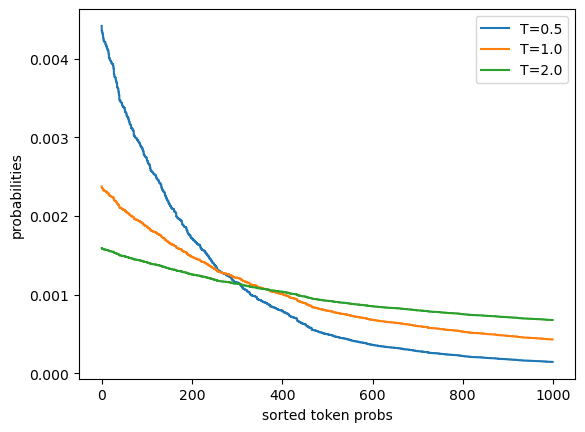

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)
for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f'T={T}')

plt.legend(loc='best')
plt.xlabel('sorted token probs')
plt.ylabel('probabilities')
plt.show()

In [24]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Artificial intelligence is transforming the way we interact with computers, making it possible to communicate with machines, predict events, and even perform everyday tasks.

But it's also creating a new class of artificial intelligence that is able to learn and adapt to new environments.

In a paper published in the journal Current Biology, researchers at MIT and the University of California, Berkeley, describe a new class of artificial intelligence that can learn and adapt to the environment.

"It is very exciting," said co-author and MIT professor of computer science and engineering, Andrew Ng. "It's the first time you have this kind of intelligent


# top-k and nucleus sampling

In [25]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, temperature=0.5, top_k=50)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Artificial intelligence is transforming our lives, but it's also changing the way we think about the world.

As AI gets smarter, it's changing the way we think about the world. It's changing how we think about how we live.

The question is, how do we change our mindsets so that we can move forward with the same goals we've always had?

Here are five ways AI is changing the way we think about the world.

1. We're changing our brains

We've all been taught that we're smarter than we really are. But when it comes to the brain,


# top p

In [26]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, temperature=0.5, top_p=0.90)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Artificial intelligence is transforming how we think about the world. We are already seeing the effects of this transformation in the way we interact with the world.

For example, artificial intelligence is transforming how we think about the world. We are already seeing the effects of this transformation in the way we interact with the world. We are creating a new type of communication: "text-to-speech." We are creating a new type of communication: "text-to-speech."

We are creating a new type of communication: "text-to-speech." We are creating a new type of communication: "text-to-
